# Future cases forecasting using Deep Learning - LSTM (Long 'Short Term Memory')

LSTM is one of the prominent techniques under Recurrent Neural Netrowk which is known to remember long sequences over time.

In [1]:
import time
st = time.time()

## 1. Setup
To prepare your environment, you need to install some packages.

### 1.1 Install the necessary packages

You need the latest versions of these packages:<br> We will be using Keras modules which runs on top of TensorFlow

In [2]:
!python -V

Python 3.8.11


In [3]:
!pip install tensorflow
!pip install keras==2.3.1

In [4]:
import boto3
import numpy as np 
import pandas as pd 
from keras.layers.core import Dense, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import math, time
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from numpy import newaxis
from keras.callbacks import EarlyStopping
import tensorflow as tf
%matplotlib inline
from keras.models import load_model
from keras.models import model_from_json
import h5py
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


### Ingest data from S3. Update the AWS credentials in the below cell.

In [5]:
BUCKET_TYPE="s3"
BUCKET_NAME=""
BUCKET_REGION=""
AWS_ACCESS_KEY_ID=""
AWS_SECRET_ACCESS_KEY=""

In [6]:
s3 = boto3.resource(
    service_name = BUCKET_TYPE,
    region_name = BUCKET_REGION,
    aws_access_key_id = AWS_ACCESS_KEY_ID,
    aws_secret_access_key = AWS_SECRET_ACCESS_KEY
)

In [7]:
datasets = []
for obj in s3.Bucket(BUCKET_NAME).objects.all():
    datasets.append(obj.key)
datasets

['15-day-pred.csv',
 'Belgium-country-output.csv',
 'Belgium-ts.csv',
 'Data-region-RI-SM.csv',
 'Risk-Index-Output/',
 'Risk-Index_data/',
 'Risk-Index_data/Data-region-RI-SM-Scoring.csv',
 'Risk-Index_data/Data-region-RI-SM.csv',
 'Risk-Index_data/Data-region-RI.csv',
 'Risk-Index_data/RI_data.csv',
 'Risk-Index_data/test.csv',
 'Risk-Index_data/train.csv',
 'Risk-Index_data/ts-data-region-RI.csv',
 'Risk_Index/Risk_index_training_recoded.csv',
 'flanders-output.csv',
 'my_pred_model_Belgium.h5',
 'my_pred_model_Flanders.h5',
 'pred-data-15.csv',
 'pred-data.csv',
 'pred-models/',
 'raw-data/',
 'raw-data/COVID19BE_CASES_AGESEX.csv',
 'raw-data/COVID19BE_HOSP.csv',
 'test-data.csv',
 'test-y-data.csv',
 'time-series-data/',
 'time-series-data/formatted/',
 'time-series-data/formatted/Belgium-ts.csv',
 'time-series-data/formatted/forecast-data-15.csv',
 'time-series-data/formatted/results/',
 'time-series-data/formatted/ts-Brussels-grouped.csv',
 'time-series-data/formatted/ts-Brussel

In [8]:
obj = s3.Bucket(BUCKET_NAME).Object('Belgium-ts.csv').get()
data = pd.read_csv(obj['Body'], index_col=0)
data.head()

,Total_cases
DATE,
2020-03-15,963
2020-03-16,1600
2020-03-17,2287
2020-03-18,3233
2020-03-19,4040


# Fix random seed for reproducibility

In [9]:
tf.random.set_seed(1011)

In [10]:
series = data
series = series.astype(float)

# Plot the data

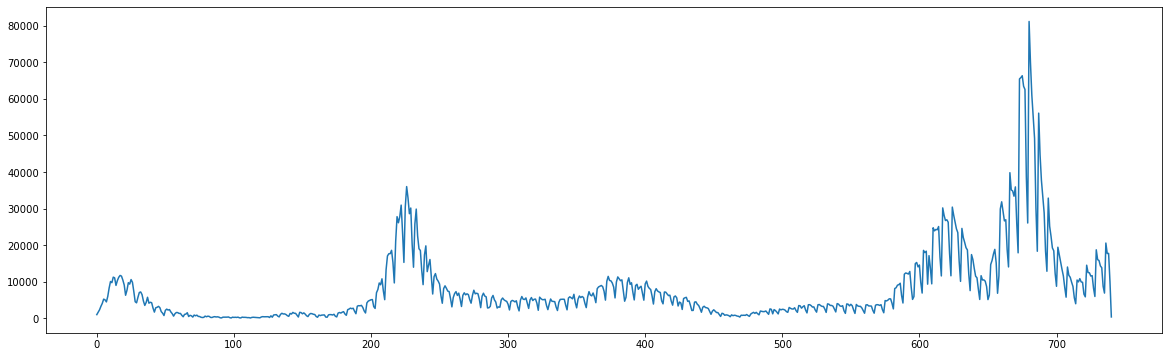

In [11]:
plt.figure(figsize=(20,6))
plt.plot(series.values)
plt.show()

# Normalize the data

In [12]:
series = series.values
scaler = MinMaxScaler(feature_range=(0, 1))
series = scaler.fit_transform(series)

# Split the data into train and test with 80:20 ratio

In [13]:
train_size = int(len(series) * 0.80)
test_size = len(series) - train_size
train, test = series[0:train_size,:], series[train_size:len(series),:]
print(len(train), len(test))

592 149


# Helper function to generate the dataset with input(X) & output(Y) variables

In [14]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# Create a dataset with a look back period of 'x' observations

This is where we convert the time series problem into a regression problem

In [15]:
look_back = 15
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# Review the shape of datasets

In [16]:
trainX.shape

(576, 15)

In [17]:
testX.shape

(133, 15)

# Reshape the data to 3D

The LSTM model requires the input data to be three dimensional

In [18]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [19]:
trainX.shape

(576, 15, 1)

# Define the LSTM model

Activation function will activate the neurons for the learning. Rectified linear unit (ReLu) is one of the most popular activations because the output does not go beyond 0.

Units will be the number of neurons in the input & hidden layers.

Stateful is where we define whether the previous information has to be remembered or not.

Dropout is where we omit random neurons for each layer as per the value (0 to 1). In this case we omit 20% of the neurons.

Optimiser is where the weights are back propagated through the network to enhance the learnings closer to the desired outcome. Adam optimiser is an efficient method for enhanced accuracy.

In [20]:
print('Build Model...')
model = Sequential()
model.add(LSTM(input_shape=(15,1), kernel_initializer="uniform", return_sequences=True, stateful=False, units=90))
model.add(Dropout(0.25))
model.add(LSTM(100, kernel_initializer="uniform", activation='relu',return_sequences=False))
model.add(Dropout(0.15))
model.add(Dense(32,kernel_initializer="uniform",activation='relu'))
model.add(Dense(1, activation='linear'))
#optimizer = Adam(lr=0.0005)
#model.compile(loss="mse", optimizer=optimizer)
model.compile(loss="mse", optimizer='adam')
model.summary()

Build Model...
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 15, 90)            33120     
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 90)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               76400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                3232      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 112,785
Trainable params: 112,785
Non-trainable params: 0
_________________________________

# Params Calculation

params = 4 * (size_of_input + 1 * size_of_output) + 4 * size_of_output^2

# Optimize computation time using early stopping

We monitor the accuracy of validation loss ('val_loss') and end the training if there's no improvement in the accuracy after five iterations ('patience=5').

In [21]:
'''One of the methods to optimize computation time'''

early_stopping=EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')

# Fitting the model for training data

In [22]:
start = time.time()
history = model.fit(trainX, trainY, batch_size=32, epochs=25, verbose=1, shuffle=False, validation_split=0.10, callbacks=[early_stopping])
print("> Compilation Time : ", time.time() - start)

Train on 518 samples, validate on 58 samples
Epoch 1/25
518/518 [==============================] - 2s 5ms/step - loss: 0.0060 - val_loss: 0.0011
Epoch 2/25
518/518 [==============================] - 1s 3ms/step - loss: 0.0047 - val_loss: 8.9717e-04
Epoch 3/25
518/518 [==============================] - 1s 3ms/step - loss: 0.0043 - val_loss: 9.6622e-04
Epoch 4/25
518/518 [==============================] - 1s 3ms/step - loss: 0.0037 - val_loss: 6.5772e-04
Epoch 5/25
518/518 [==============================] - 1s 3ms/step - loss: 0.0026 - val_loss: 6.6280e-04
Epoch 6/25
518/518 [==============================] - 1s 3ms/step - loss: 0.0019 - val_loss: 7.3426e-04
Epoch 7/25
518/518 [==============================] - 1s 3ms/step - loss: 0.0019 - val_loss: 5.5740e-04
Epoch 8/25
518/518 [==============================] - 1s 3ms/step - loss: 0.0017 - val_loss: 5.6186e-04
Epoch 9/25
518/518 [==============================] - 1s 3ms/step - loss: 0.0016 - val_loss: 5.9698e-04
Epoch 10/25
518/518 [==

# Create a function to calculate accuracy

We will be using 'Mean Squared Error' & 'Root Mean Squared Error' functions to calculate accuracy

In [23]:
def model_score(model, trainX, trainY, testX, testY):
    trainScore = model.evaluate(trainX, trainY, batch_size=72, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
    print('Train Accuracy: %.2f %%' % (100 - math.sqrt(trainScore)*100))

    testScore = model.evaluate(testX, testY, batch_size=72, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))
    print('Test Accuracy: %.2f %%' % (100 - math.sqrt(testScore)*100))
    return trainScore, testScore

# Check the Accuracy of the model

In [24]:
model_score(model, trainX, trainY, testX, testY)

Train Score: 0.00092 MSE (0.03 RMSE)
Train Accuracy: 96.96 %
Test Score: 0.01714 MSE (0.13 RMSE)
Test Accuracy: 86.91 %


(0.0009244939856216661, 0.017139727767921033)

# Review the learning of training & validation loss (error evaluation)

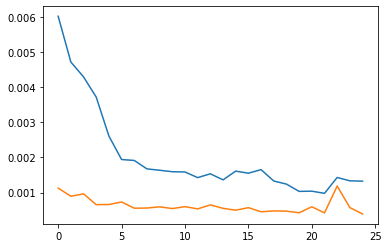

In [25]:
'''Review the learning'''

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

# Get the configuration of the model

This will give us an idea about all the parameters available and which ones have been choosen.

In [26]:
model.get_config()

{'name': 'sequential_1',
 'layers': [{'class_name': 'LSTM',
   'config': {'name': 'lstm_1',
    'trainable': True,
    'batch_input_shape': (None, 15, 1),
    'dtype': 'float32',
    'return_sequences': True,
    'return_state': False,
    'go_backwards': False,
    'stateful': False,
    'unroll': False,
    'units': 90,
    'activation': 'tanh',
    'recurrent_activation': 'sigmoid',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'RandomUniform',
     'config': {'minval': -0.05, 'maxval': 0.05, 'seed': None}},
    'recurrent_initializer': {'class_name': 'Orthogonal',
     'config': {'gain': 1.0, 'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'unit_forget_bias': True,
    'kernel_regularizer': None,
    'recurrent_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'recurrent_constraint': None,
    'bias_constraint': None,
    'dropout': 0.0,
    'recurrent_dropout': 

# Create a function to plot predicted vs actual values

In [27]:
def plot_the_results(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white', figsize=(16,8))
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.plot(padding + data, 'b^')
    plt.show()

# Create a function to predict future values

In [28]:
def predict_the_sequences(model, data, window_size, prediction_len):
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

### Predict future values & plot the results

In this case, we are predicting the current values.
If we need to predict t+1 then the prediction_len parameter has to be changed to 2
and if we need t+2 then prediction_len would be 3.

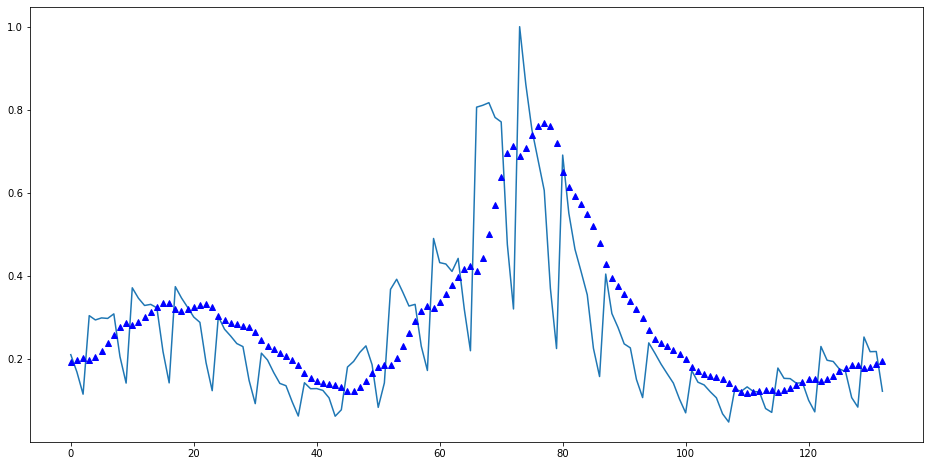

In [29]:
predictions = predict_the_sequences(model, testX, 15, 1)

plot_the_results(predictions, testY, 1)

In [30]:
predictions1 = predict_the_sequences(model, testX, 15, 15)

In [31]:
predictions1

[[0.19263549,
  0.19695488,
  0.20155004,
  0.20600352,
  0.210376,
  0.21498106,
  0.22050244,
  0.22624731,
  0.23203877,
  0.23799492,
  0.24363528,
  0.24909936,
  0.25560984,
  0.26218948,
  0.2689037],
 [0.33533072,
  0.34486696,
  0.35343245,
  0.36117485,
  0.3699171,
  0.37850097,
  0.38707802,
  0.39565167,
  0.40433145,
  0.412355,
  0.41995347,
  0.42922705,
  0.43839645,
  0.4474803,
  0.45662355],
 [0.26556394,
  0.26066965,
  0.25927445,
  0.26255533,
  0.26745987,
  0.27343476,
  0.27998263,
  0.2869961,
  0.29359955,
  0.29988432,
  0.30753034,
  0.31509593,
  0.3226454,
  0.330154,
  0.33769885],
 [0.123148136,
  0.11871759,
  0.11799256,
  0.11912854,
  0.12138128,
  0.124280185,
  0.1275973,
  0.13086647,
  0.13406448,
  0.13796374,
  0.14190826,
  0.1459599,
  0.15007167,
  0.15412661,
  0.15791781],
 [0.33593625,
  0.34704942,
  0.35701206,
  0.36628845,
  0.3751505,
  0.3834308,
  0.3907499,
  0.39839795,
  0.40762514,
  0.41703233,
  0.4262418,
  0.4352548,
  0.

In [32]:
predictions1 = scaler.inverse_transform(predictions1)
results1 = pd.DataFrame(np.round(predictions1[-10:]))
print(results1)

        0        1        2        3        4        5        6        7   \
0  15678.0  16028.0  16401.0  16763.0  17117.0  17491.0  17939.0  18405.0   
1  27257.0  28031.0  28726.0  29354.0  30064.0  30760.0  31456.0  32152.0   
2  21596.0  21199.0  21085.0  21352.0  21750.0  22234.0  22766.0  23335.0   
3  10039.0   9680.0   9621.0   9713.0   9896.0  10131.0  10400.0  10665.0   
4  27306.0  28208.0  29016.0  29769.0  30488.0  31160.0  31754.0  32375.0   
5  59947.0  61620.0  62967.0  64069.0  65034.0  65814.0  66466.0  67443.0   
6  29013.0  28428.0  28392.0  28687.0  29065.0  29501.0  30334.0  31119.0   
7  12664.0  12591.0  12706.0  12899.0  13141.0  13510.0  13899.0  14296.0   

        8        9        10       11       12       13       14  
0  18875.0  19359.0  19816.0  20260.0  20788.0  21322.0  21867.0  
1  32856.0  33507.0  34124.0  34876.0  35621.0  36358.0  37100.0  
2  23871.0  24381.0  25001.0  25615.0  26228.0  26837.0  27449.0  
3  10925.0  11241.0  11561.0  11890.0 

## Create a dataframe for predicted results

In [33]:
results=pd.DataFrame(np.round(predictions1[-1:]))
results

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,12664.0,12591.0,12706.0,12899.0,13141.0,13510.0,13899.0,14296.0,14694.0,15088.0,15466.0,15831.0,16260.0,16684.0,17110.0


## Save the predicted output to S3 

In [34]:
from io import StringIO
import boto3

#Creating Session With Boto3.

session = boto3.Session(
aws_access_key_id=AWS_ACCESS_KEY_ID,
aws_secret_access_key=AWS_SECRET_ACCESS_KEY
)

#Creating S3 Resource From the Session.
s3_res = session.resource('s3')
csv_buffer = StringIO()
results.to_csv(csv_buffer,index=False)

bucket_name = BUCKET_NAME
s3_object_name = 'Belgium-country-output.csv'

s3_res.Object(bucket_name, s3_object_name).put(Body=csv_buffer.getvalue())
print("Dataframe is saved as CSV in S3 bucket.")

Dataframe is saved as CSV in S3 bucket.


## Follow the earlier steps with multiple iterations by changing the hyperparameters for better understanding of the flow.

We can use model.save(filepath) to save a Keras model into a single HDF5 file which will contain:

The architecture of the model, allowing to re-create the model.

The weights of the model.

The training configuration (loss, optimizer).

The state of the optimizer, allowing to resume training exactly where you left off.

# Transfer Learning

Save the model for future use on new data

## Get the current working directory

In [35]:
import os
os.getcwd()

'/home/wsuser/work'

## Save the model to home directory

In [36]:
model.save('/home/wsuser/work/my_pred_model_Belgium.h5')
print('Model saved to disc')

Model saved to disc


## Save the model to S3 Bucket

In [37]:
from keras.models import load_model
import boto3

session = boto3.Session(
aws_access_key_id=AWS_ACCESS_KEY_ID,
aws_secret_access_key=AWS_SECRET_ACCESS_KEY
)

csv_buffer = StringIO()

bucket_name = BUCKET_NAME
s3_object_name = 'my_pred_model_Belgium.h5'

s3_res.Object(bucket_name, s3_object_name).put(Body=csv_buffer.getvalue())
print('Model saved to S3 bucket')

Model saved to S3 bucket


# Load the model

In [38]:
model = load_model('/home/wsuser/work/my_pred_model_Belgium.h5')
print('Model loaded to the session')

Model loaded to the session


# Methodology to save the model's architecture and weights for reusability in the future
We can use these weights alone which has the learnings on other data.

In [39]:
model_json = model.to_json()
with open('/home/wsuser/work/my_pred_model_Belgium.json', "w") as json_file:
    json_file.write(model_json)

model.save_weights("/home/wsuser/work/pred_model_Belgium_weights.h5")
print("Saved model & weights to disk")

Saved model & weights to disk


# By loading the model architecture, we can rebuild the model with different configuration

We can also use the existing weights on the new architecture.

In [40]:
json_file = open('/home/wsuser/work/my_pred_model_Belgium.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)


loaded_model.load_weights("/home/wsuser/work/pred_model_Belgium_weights.h5")
print("Loaded model & weights from disk")

Loaded model & weights from disk


We can sum up the learnings of LSTM and its advantages. We have learned how to create and deploy a deep learning model, save the model, architecture & weights for future use. We have also learned how to evaluate the model & tune the parameters. LSTM is a very popular technique which can be applied to different usecases and can produce great results. 

In [41]:
time_taken=round(time.time() - st,1)
print("The Notebook ran in {} ".format(float(time_taken)) + "seconds")

The Notebook ran in 46.5 seconds


### In this Notebook, we learnt how to build deep learning model & generate forecasts at country level. We also learnt how to save the model's architecture and weights to the S3 bucket.